In [108]:
import pandas as pd
import numpy as np
import torch
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
import torch.optim as optim
import matplotlib.pyplot as plt
from torch_geometric.loader import DataLoader
from torch_geometric.data import Data

# Load Data

In [135]:
u_cols = ['user_id', 'age', 'sex', 'occupation', 'zip_code']
users = pd.read_csv('ml-100k/u.user', sep='|', names=u_cols, encoding='latin-1')
users['user_id']=users['user_id']-1

i_cols = ['movie_id', 'movie_title', 'release_date', 'video_release_date', 'IMBd_URL', 'unknown', 'Action', 'Adventure',
          'Animation', 'Children', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', 'Firm-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']
items = pd.read_csv('ml-100k/u.item', sep='|', names=i_cols, encoding='latin-1')
items['movie_id']=items['movie_id']-1
genre_list = [
    'unknown', 'Action', 'Adventure', 'Animation', "Children", 'Comedy', 'Crime', 'Documentary', 
    'Drama', 'Fantasy', 'Firm-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 
    'Thriller', 'War', 'Western'
]

r_cols = ['user_id', 'movie_id', 'rating', 'timestamp']
ratings = pd.read_csv('ml-100k/u.data', sep='\t', names =  r_cols, encoding='latin-1')
ratings['user_id']=ratings['user_id']-1
ratings['movie_id']=ratings['movie_id']-1

ratings['timestamp'] = pd.to_datetime(ratings['timestamp'], unit='s')
ratings['day_of_week'] = ratings['timestamp'].dt.dayofweek
ratings['hour'] = ratings['timestamp'].dt.hour
ratings['time_of_day'] = pd.cut(ratings['hour'],
                                bins=[0, 6, 12, 18, 24],
                                labels=[0, 1, 2, 3],
                                include_lowest=True)
ratings['month'] = ratings['timestamp'].dt.month
ratings['is_weekend'] = ratings['day_of_week'].isin([5, 6]).astype(int)
ratings['season'] = pd.cut(ratings['month'], 
                                bins=[0, 3, 6, 9, 12], 
                                labels=[0,1,2,3])

In [110]:
label_encoder = LabelEncoder()
users['sex'] = label_encoder.fit_transform(users['sex'])
users['occupation'] = label_encoder.fit_transform(users['occupation'])
bins = [0, 18, 30, 45, 60, 150]
labels = list(range(len(bins)-1))
users['age'] = pd.cut(users['age'], bins=bins, labels=labels, right=False)

user_features = pd.get_dummies(users, columns=['age', 'sex', 'occupation'])

user_features = user_features.drop(['user_id', 'zip_code'], axis=1).astype(float)
user_features = torch.tensor(user_features.values, dtype=torch.float)
print(user_features[:5])
print(user_features.shape)

tensor([[0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]])
torch.Size([943, 28])


In [111]:
item_features = items.to_numpy()
item_features = item_features[:, -19:]
item_features = item_features.astype(float)
item_features = torch.tensor(item_features, dtype=torch.float)
print(item_features[:5])
print(item_features.shape)

tensor([[0., 0., 0., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0.],
        [0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
         0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
         0.],
        [0., 1., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
         0.]])
torch.Size([1682, 19])


In [112]:
def extract_context_features(ratings):
    day_of_week_ohe = pd.get_dummies(ratings['day_of_week'], prefix='day_of_week')
    time_of_day_ohe = pd.get_dummies(ratings['time_of_day'], prefix='time_of_day')
    month_ohe = pd.get_dummies(ratings['month'], prefix='month')
    is_weekend_ohe = pd.get_dummies(ratings['is_weekend'], prefix='is_weekend')
    season_ohe = pd.get_dummies(ratings['season'], prefix='season')
    context_features = pd.concat([day_of_week_ohe, time_of_day_ohe, month_ohe, is_weekend_ohe, season_ohe], axis=1)

    context_features = torch.tensor(context_features.values, dtype=torch.float)
    return context_features

In [113]:
context_features = extract_context_features(ratings)
print(context_features[:5])
context_features.shape

tensor([[0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
         1., 1., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0.,
         0., 0., 1., 0., 1., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         0., 1., 0., 0., 0., 0., 1.],
        [0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         0., 1., 0., 0., 0., 0., 1.],
        [1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
         0., 1., 0., 1., 0., 0., 0.]])


torch.Size([100000, 25])

In [114]:

num_users = user_features.shape[0]
num_items = item_features.shape[0]
NUM_USER=num_users


In [115]:
feature_matrix = torch.zeros((num_users + num_items, user_features.shape[1] + item_features.shape[1]))
feature_matrix[:num_users, :user_features.shape[1]] = user_features
feature_matrix[num_users:, user_features.shape[1]:] = item_features

In [116]:
num_features=feature_matrix.shape[1]

In [117]:
def create_interaction_graph(ratings, features):
    # Tạo ma trận kết nối sparse hiệu quả
    user_ids = ratings['user_id'].values
    item_ids = ratings['movie_id'].values + num_users
    ratings_values = ratings['rating'].values
            
    # Tạo edge_index
    edge_index = torch.tensor([
        np.concatenate([user_ids, item_ids]),
        np.concatenate([item_ids, user_ids])
    ], dtype=torch.long)
    
    # Tạo edge_attr
    edge_attr = torch.tensor(
        np.concatenate([ratings_values, ratings_values]), 
        dtype=torch.float
    )
    # Tạo PyTorch Geometric Data
    graph_data = Data(
        x=features, 
        edge_index=edge_index, 
        edge_attr=edge_attr
    )
    
    return graph_data

In [118]:
def prepare_graph_data(train_ratings, val_ratings, test_ratings, feature_matrix):
    train_data = create_interaction_graph(train_ratings, feature_matrix)
    val_data = create_interaction_graph(val_ratings, feature_matrix)
    test_data = create_interaction_graph(test_ratings, feature_matrix)

    return train_data, val_data, test_data

In [119]:
rate_train_val, rate_test = train_test_split(ratings, test_size=0.2, random_state=1)
rate_train, rate_val = train_test_split(rate_train_val, test_size=0.2, random_state=1)

train_data, val_data, test_data = prepare_graph_data(rate_train, rate_val, rate_test, feature_matrix)
train_loader = DataLoader([train_data], batch_size=16)
val_loader = DataLoader([val_data], batch_size=16)
test_loader = DataLoader([test_data], batch_size=16)

In [120]:
print(f"edge_index max: {train_data.edge_index.max()}, num_nodes: {train_data.x.size(0)}")
print(f"edge_index min: {train_data.edge_index.min()}")

edge_index max: 2624, num_nodes: 2625
edge_index min: 0


In [121]:
class GCN(torch.nn.Module):
    def __init__(self, num_features, hidden_channels):
        super(GCN, self).__init__()
        # Thêm nhiều lớp convolution
        self.conv1 = GCNConv(num_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels // 2)
        self.conv3 = GCNConv(hidden_channels // 2, hidden_channels)
        self.dropout = torch.nn.Dropout(0.5)
    
    def forward(self, x, edge_index, edge_attr):
        x = F.relu((self.conv1(x, edge_index, edge_weight=edge_attr)))
        x = self.dropout(x)
        x = F.relu((self.conv2(x, edge_index, edge_weight=edge_attr)))
        x = self.dropout(x)
        x = self.conv3(x, edge_index, edge_weight=edge_attr)
        return x

In [122]:
hidden_channels = 256
model = GCN(num_features=feature_matrix.shape[1], hidden_channels=hidden_channels)
optimizer = optim.AdamW(model.parameters(), lr=0.0005, weight_decay=1e-5)
criterion = torch.nn.MSELoss()


def train(model, train_loader, optimizer, criterion):
    model.train()
    total_loss = 0
    for data in train_loader:
        optimizer.zero_grad()
        out = model(data.x, data.edge_index, data.edge_attr)
        edge_scores = (out[data.edge_index[0]] * out[data.edge_index[1]]).sum(dim=1)
        loss = torch.sqrt(criterion(edge_scores, data.edge_attr.to(torch.float)))
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(train_loader)



def validate(model, val_loader, criterion):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for data in val_loader:
            out = model(data.x, data.edge_index, data.edge_attr)
            source_embeddings = out[data.edge_index[0]]
            target_embeddings = out[data.edge_index[1]]
            edge_scores = (source_embeddings * target_embeddings).sum(dim=1)
            target = data.edge_attr.to(torch.float)
            loss = torch.sqrt(criterion(edge_scores, target))
            total_loss += loss.item()
    return total_loss / len(val_loader)

def test(model, test_loader, criterion):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for data in test_loader:
            out = model(data.x, data.edge_index, data.edge_attr)
            source_embeddings = out[data.edge_index[0]]
            target_embeddings = out[data.edge_index[1]]
            edge_scores = (source_embeddings * target_embeddings).sum(dim=1)
            target = data.edge_attr.to(torch.float)
            loss = torch.sqrt(criterion(edge_scores, target))
            total_loss += loss.item()
    return total_loss / len(test_loader)

In [123]:
train_losses = []
val_losses = []
num_epochs = 300
for epoch in range(num_epochs):
    train_loss = train(model, train_loader, optimizer, criterion)
    val_loss = validate(model, val_loader, criterion)

    train_losses.append(train_loss)
    val_losses.append(val_loss)

    if (epoch + 1) % 10 == 0:
        print(f'Epoch {epoch + 1}, Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}')


Epoch 10, Train Loss: 1.7721, Validation Loss: 1.9428
Epoch 20, Train Loss: 1.8560, Validation Loss: 1.8431
Epoch 30, Train Loss: 1.7398, Validation Loss: 1.7328
Epoch 40, Train Loss: 1.7073, Validation Loss: 1.6713
Epoch 50, Train Loss: 1.6557, Validation Loss: 1.6270
Epoch 60, Train Loss: 1.6207, Validation Loss: 1.5898
Epoch 70, Train Loss: 1.5727, Validation Loss: 1.5502
Epoch 80, Train Loss: 1.5374, Validation Loss: 1.5068
Epoch 90, Train Loss: 1.4883, Validation Loss: 1.4595
Epoch 100, Train Loss: 1.4366, Validation Loss: 1.4109
Epoch 110, Train Loss: 1.3779, Validation Loss: 1.3613
Epoch 120, Train Loss: 1.3297, Validation Loss: 1.3263
Epoch 130, Train Loss: 1.2901, Validation Loss: 1.2802
Epoch 140, Train Loss: 1.2385, Validation Loss: 1.2327
Epoch 150, Train Loss: 1.2071, Validation Loss: 1.1960
Epoch 160, Train Loss: 1.1690, Validation Loss: 1.1737
Epoch 170, Train Loss: 1.1349, Validation Loss: 1.1900
Epoch 180, Train Loss: 1.1619, Validation Loss: 1.1117
Epoch 190, Train Lo

In [124]:
test_loss = test(model, test_loader, criterion)
print(f'Test Loss (RMSE): {test_loss:.4f}')

Test Loss (RMSE): 1.0839


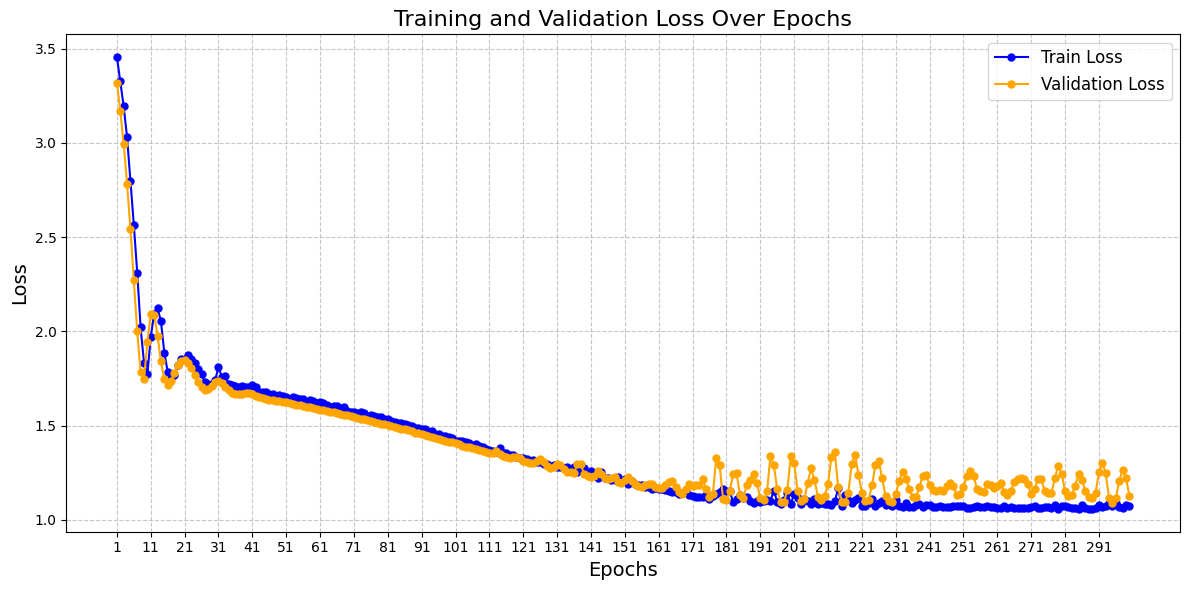

In [125]:
plt.figure(figsize=(12, 6))
plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss', color='blue', marker='o', markersize=5, linestyle='-')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss', color='orange', marker='o', markersize=5, linestyle='-')
plt.title('Training and Validation Loss Over Epochs', fontsize=16)
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.xticks(range(1, num_epochs + 1, 10))
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [131]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

def evaluate_model(model, data_loader):
    model.eval()
    true_ratings = []
    pred_ratings = []
    
    with torch.no_grad():
        for data in data_loader:
            edge_index = data.edge_index
            edge_attr = data.edge_attr
            out = model(data.x, edge_index, edge_attr)
            
            source_embeddings = out[edge_index[0]]
            target_embeddings = out[edge_index[1]]
            edge_scores = (source_embeddings * target_embeddings).sum(dim=1)
            
            true_ratings.extend(edge_attr.cpu().numpy())
            pred_ratings.extend(edge_scores.cpu().numpy())
    
    true_ratings = np.array(true_ratings)
    pred_ratings = np.array(pred_ratings)
    
    threshold = 3
    true_binary = (true_ratings >= threshold).astype(int)
    pred_binary = (pred_ratings >= threshold).astype(int)
    
    accuracy = accuracy_score(true_binary, pred_binary)
    f1 = f1_score(true_binary, pred_binary)
    precision = precision_score(true_binary, pred_binary)
    recall = recall_score(true_binary, pred_binary)
    
    return {
        'Accuracy': accuracy,
        'F1 Score': f1,
        'Precision': precision,
        'Recall': recall
    }

train_metrics = evaluate_model(model, train_loader)
print("Train Metrics:")
for metric, value in train_metrics.items():
    print(f"{metric}: {value}")

val_metrics = evaluate_model(model, val_loader)
print("\nValidation Metrics:")
for metric, value in val_metrics.items():
    print(f"{metric}: {value}")

val_metrics = evaluate_model(model, test_loader)
print("\nTest Metrics:")
for metric, value in val_metrics.items():
    print(f"{metric}: {value}")

Train Metrics:
Accuracy: 0.761140625
F1 Score: 0.8527306532566497
Precision: 0.8675657662602423
Recall: 0.8383943624618765

Validation Metrics:
Accuracy: 0.807125
F1 Score: 0.8889688421961575
Precision: 0.8497145608363711
Recall: 0.9320256506978498

Test Metrics:
Accuracy: 0.79735
F1 Score: 0.8815777940102264
Precision: 0.8499633782184912
Recall: 0.9156348628307842


In [136]:
def get_recommendations(user_id, top_k=10):
    model.eval()
    with torch.no_grad():
        rated_movies = set(ratings[ratings['user_id'] == user_id]['movie_id'].values)
        out = model(train_data.x, train_data.edge_index, train_data.edge_attr)
        user_embedding = out[user_id]
        item_embeddings = out[num_users:num_users + num_items]
        
        scores = torch.matmul(user_embedding.unsqueeze(0), item_embeddings.t()).squeeze()
        scores = scores.cpu().numpy()
        
        movie_scores = [(i, score) for i, score in enumerate(scores)]
        unrated_movies = [(i, score) for i, score in movie_scores if i not in rated_movies]
        
        recommendations = sorted(unrated_movies, key=lambda x: x[1], reverse=True)[:top_k]
        recommended_movies = []
        for movie_id, score in recommendations:
            movie_info = items[items['movie_id'] == movie_id].iloc[0]
            recommended_movies.append({
                'movie_id': int(movie_id),
                'title': movie_info['movie_title'],
                'score': float(score),
                'genres': movie_info[genre_list].loc[movie_info[genre_list] == 1].index.tolist()
            })
            
        return recommended_movies


In [137]:
def display_recommendations(recommendations):
    print("\nTop Movie Recommendations:")
    print("-" * 80)
    print("Title                                             Predicted Rating    Genres")
    print("-" * 80)
    for rec in recommendations:
        title = rec['title'][:47] + "..." if len(rec['title']) > 47 else rec['title']
        title = title.ljust(50) 
        score = f"{rec['score']:.2f}".ljust(20)
        genres = ', '.join(rec['genres'])
        print(f"{title}{score}{genres}")


In [138]:
user_id = 1
recommendations = get_recommendations(user_id, top_k=10)
display_recommendations(recommendations)


Top Movie Recommendations:
--------------------------------------------------------------------------------
Title                                             Predicted Rating    Genres
--------------------------------------------------------------------------------
Bloody Child, The (1996)                          6.45                Drama, Thriller
Heavy (1995)                                      5.89                Drama, Romance
Tough and Deadly (1995)                           5.25                Action, Drama, Thriller
Tainted (1998)                                    4.83                Comedy, Thriller
Stefano Quantestorie (1993)                       4.59                Comedy, Drama
Reluctant Debutante, The (1958)                   4.59                Comedy, Drama
Nothing Personal (1995)                           4.59                Drama, War
Cyclo (1995)                                      4.44                Crime, Drama
Angel on My Shoulder (1946)                      

In [139]:
from collections import Counter
from sklearn.metrics.pairwise import cosine_similarity

In [140]:
def evaluate_recommendations(user_id, top_k=10):
    # Lấy recommendations cho user
    recommendations = get_recommendations(user_id, top_k)
    recommended_movie_ids = [rec['movie_id'] for rec in recommendations]
    
    # Lấy các đánh giá thực tế của user
    user_ratings = ratings[ratings['user_id'] == user_id]
    
    # Tính toán các metrics
    def calculate_similarity_metrics(rated_movies, recommended_movies):
        # Lấy thông tin thể loại của phim
        rated_genres = items[items['movie_id'].isin(rated_movies)][genre_list].mean()
        recommended_genres = items[items['movie_id'].isin(recommended_movies)][genre_list].mean()
        
        # Tính cosine similarity giữa profile thể loại
        genre_similarity = cosine_similarity([rated_genres], [recommended_genres])[0][0]
        
        return genre_similarity

    # Lấy các phim được đánh giá cao (rating >= 4)
    highly_rated = user_ratings[user_ratings['rating'] >= 4]['movie_id'].values
    
    # Tính genre similarity
    genre_similarity = calculate_similarity_metrics(highly_rated, recommended_movie_ids)
    
    # Tính average rating của user
    avg_user_rating = user_ratings['rating'].mean()
    
    # Phân tích các thể loại yêu thích
    favorite_genres = []
    for genre in genre_list:
        genre_movies = items[items[genre] == 1]['movie_id']
        genre_ratings = user_ratings[user_ratings['movie_id'].isin(genre_movies)]['rating']
        if len(genre_ratings) > 0:
            avg_genre_rating = genre_ratings.mean()
            if avg_genre_rating >= 4:
                favorite_genres.append((genre, avg_genre_rating))
    
    favorite_genres.sort(key=lambda x: x[1], reverse=True)
    
    # Phân tích recommendations
    recommended_genres = []
    for movie_id in recommended_movie_ids:
        movie_genres = items[items['movie_id'] == movie_id][genre_list].iloc[0]
        movie_genres = [genre for genre, has_genre in zip(genre_list, movie_genres) if has_genre == 1]
        recommended_genres.extend(movie_genres)
    
    genre_counts = Counter(recommended_genres)
    
    return {
        'user_id': user_id,
        'average_rating': avg_user_rating,
        'genre_similarity': genre_similarity,
        'favorite_genres': favorite_genres[:3],  # Top 3 favorite genres
        'recommended_genre_distribution': dict(genre_counts.most_common()),
        'recommendations': recommendations
    }

def print_evaluation_results(eval_results):
    print(f"\nEvaluation Results for User {eval_results['user_id']}")
    print("-" * 50)
    print(f"Average Rating: {eval_results['average_rating']:.2f}")
    print(f"Genre Similarity with Highly Rated Movies: {eval_results['genre_similarity']:.2f}")
    
    print("\nTop 3 Favorite Genres:")
    for genre, rating in eval_results['favorite_genres']:
        print(f"- {genre}: {rating:.2f}")
    
    print("\nRecommended Genre Distribution:")
    for genre, count in eval_results['recommended_genre_distribution'].items():
        print(f"- {genre}: {count}")
    
    print("\nRecommended Movies:")
    for i, movie in enumerate(eval_results['recommendations'], 1):
        print(f"{i}. {movie['title']} (Score: {movie['score']:.4f})")


In [141]:
user_id = 1
eval_results = evaluate_recommendations(user_id)
print_evaluation_results(eval_results)


Evaluation Results for User 1
--------------------------------------------------
Average Rating: 3.71
Genre Similarity with Highly Rated Movies: 0.90

Top 3 Favorite Genres:
- Firm-Noir: 4.50
- Adventure: 4.33
- Romance: 4.12

Recommended Genre Distribution:
- Drama: 9
- Thriller: 4
- Comedy: 3
- Crime: 2
- Romance: 1
- Action: 1
- War: 1

Recommended Movies:
1. Bloody Child, The (1996) (Score: 6.4475)
2. Heavy (1995) (Score: 5.8924)
3. Tough and Deadly (1995) (Score: 5.2532)
4. Tainted (1998) (Score: 4.8317)
5. Stefano Quantestorie (1993) (Score: 4.5899)
6. Reluctant Debutante, The (1958) (Score: 4.5899)
7. Nothing Personal (1995) (Score: 4.5898)
8. Cyclo (1995) (Score: 4.4439)
9. Angel on My Shoulder (1946) (Score: 4.4439)
10. Silence of the Lambs, The (1991) (Score: 4.3853)


In [142]:
# Đánh giá tổng thể cho nhiều users
def evaluate_multiple_users(num_users=10):
    user_sample = np.random.choice(users['user_id'].unique(), num_users, replace=False)
    overall_genre_similarity = []
    
    for user_id in user_sample:
        eval_results = evaluate_recommendations(user_id)
        overall_genre_similarity.append(eval_results['genre_similarity'])
    
    print("\nOverall Evaluation Results")
    print("-" * 50)
    print(f"Average Genre Similarity: {np.mean(overall_genre_similarity):.2f}")
    print(f"Std Genre Similarity: {np.std(overall_genre_similarity):.2f}")

# Đánh giá cho nhiều users
evaluate_multiple_users()


Overall Evaluation Results
--------------------------------------------------
Average Genre Similarity: 0.72
Std Genre Similarity: 0.17


In [143]:
torch.save(model.state_dict(), 'gcn_model.pth')

In [144]:
model = GCN(num_features=feature_matrix.shape[1], hidden_channels=hidden_channels)
model.load_state_dict(torch.load('gcn_model.pth'))
model.eval()


GCN(
  (conv1): GCNConv(47, 256)
  (conv2): GCNConv(256, 128)
  (conv3): GCNConv(128, 256)
  (dropout): Dropout(p=0.5, inplace=False)
)